In [1]:
import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt
%matplotlib inline

from input_pipeline import eval_data

os.environ["CUDA_DEVICE_ORDER"]    = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ''

!echo "GPU Device in use: '$CUDA_VISIBLE_DEVICES'"

# Folders for storage/retrival
main_directory  = '../'
features_directory    = main_directory + 'features/'

GPU Device in use: ''


In [2]:
images = np.load(features_directory + 'images.npy')
labels = np.load(features_directory + 'labels.npy')

eval_images = np.load(features_directory + 'eval_images.npy')
eval_labels = np.load(features_directory + 'eval_labels.npy')

features_combined = np.load(features_directory + 'features_combined_model.npy')
eval_features_combined = np.load(features_directory + 'eval_features_combined_model.npy')

features_lstm = np.load(features_directory + 'features_lstm_model.npy')
eval_features_lstm = np.load(features_directory + 'eval_features_lstm_model.npy')

features_cnn = np.load(features_directory + 'features_cnn_model.npy')
eval_features_cnn = np.load(features_directory + 'eval_features_cnn_model.npy')

In [3]:
features_combined.shape, features_lstm.shape, features_cnn.shape

((100000, 512), (100000, 256), (100000, 256))

In [4]:
eval_features_combined.shape, eval_features_lstm.shape, eval_features_cnn.shape

((4000, 512), (4000, 256), (4000, 256))

In [4]:
# Features to load
num_samples = images.shape[0]
num_eval    = eval_images.shape[0]

In [6]:
features      = (features_cnn,      features_lstm,      features_combined)
eval_features = (eval_features_cnn, eval_features_lstm, eval_features_combined)

In [7]:
label_names = set([v.decode() for v in labels[:1000]])
label_names

{'airplane',
 'apple',
 'banana',
 'blackberry',
 'bus',
 'grapes',
 'helicopter',
 'pear',
 'truck',
 'van'}

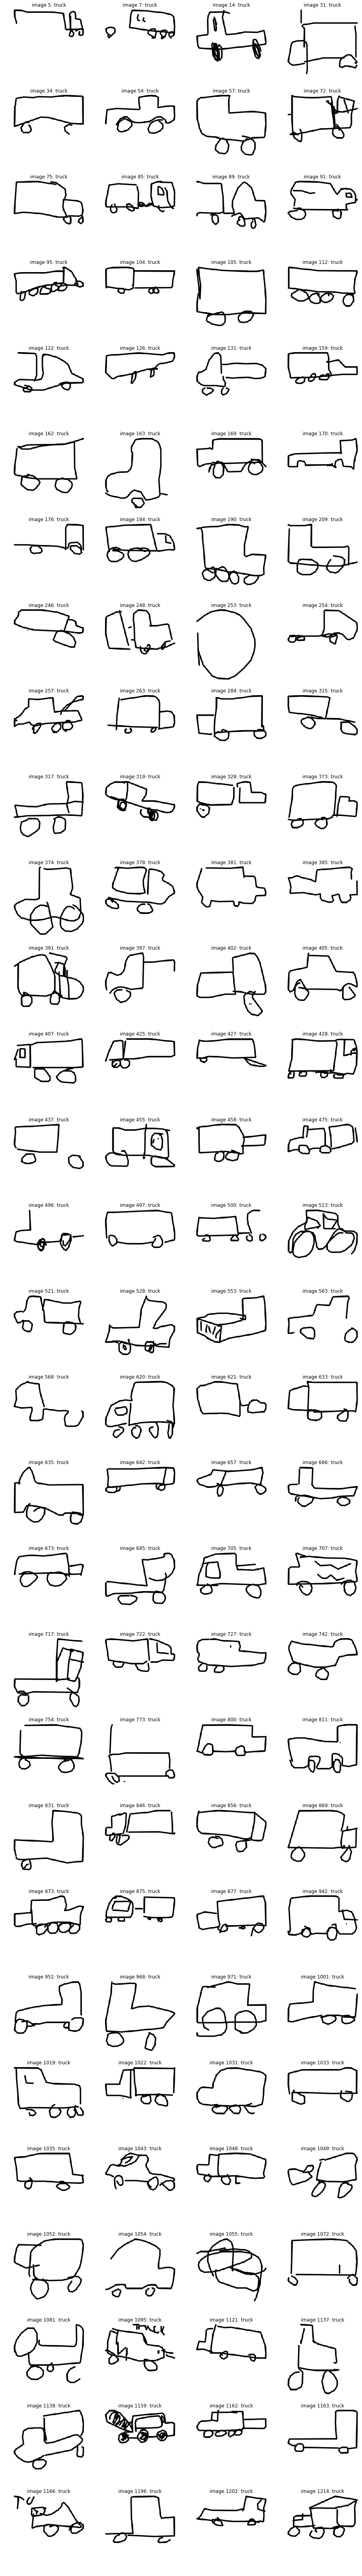

In [8]:
# Show pictures of certain label
label = 'truck'
num_cols, num_rows = 4, 60

plt.figure(figsize=(num_cols*4,num_rows*4))
index = 0
for i in range(num_cols * num_rows):
    while index < num_eval and eval_labels[index].decode() != label: index += 1
    if index >= num_eval: break
        
    plt.subplot(num_rows, num_cols,i+1)
    plt.axis('off')
    plt.title("image {}: ".format(index) + eval_labels[index].decode())
    plt.imshow(np.reshape(eval_images[index], (224,224)), cmap='gray')
    
    index += 1

In [11]:
fruit_ids   = [179, 1333, 554, 756, 556]  # apple, pear, banana, blackberry, grapes
vehicle_ids = [306, 82, 37, 885, 1721]    # airplane, helicopter, bus, van, truck
all_ids = fruit_ids + vehicle_ids

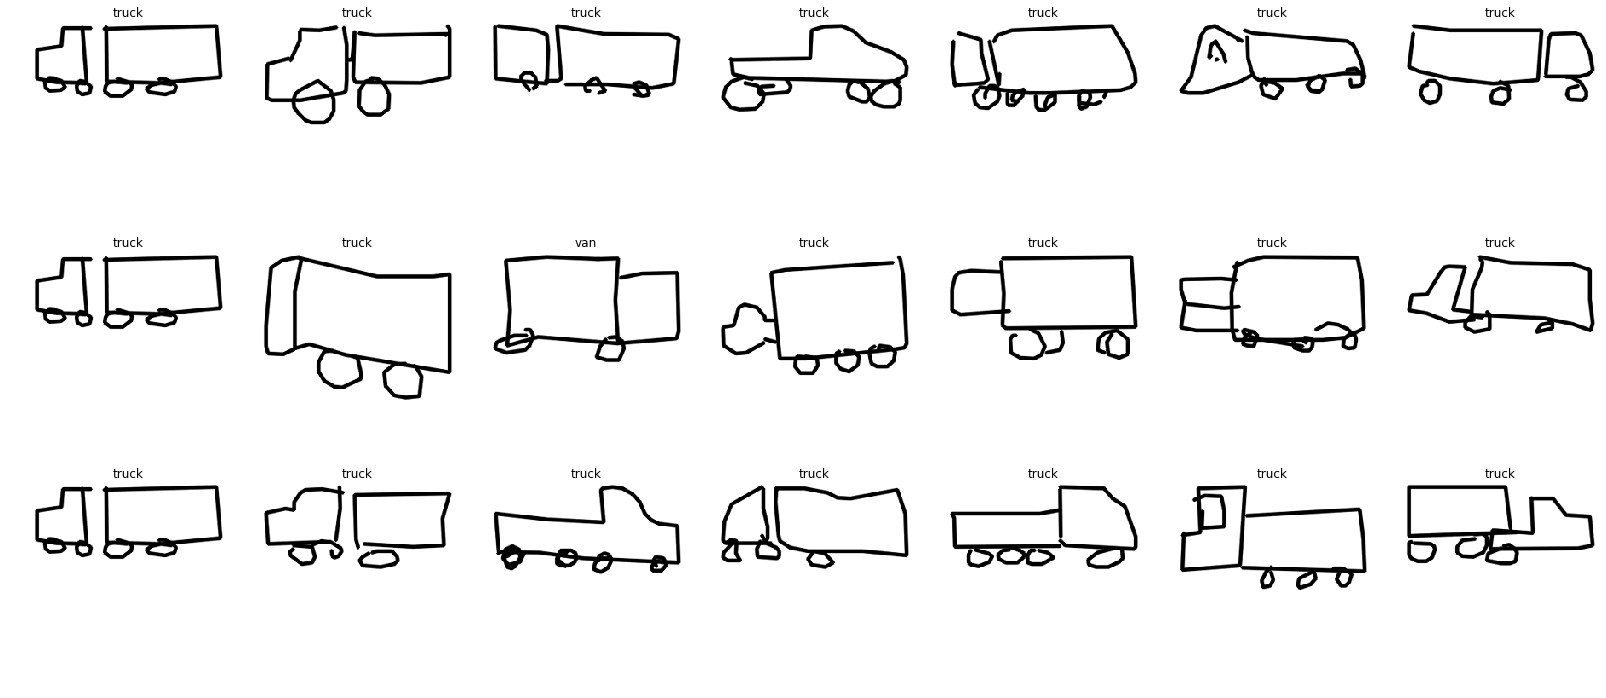

In [29]:
# for i in range(10):
index = all_ids[9]
# features = (features_vgg16, features_inception, features_resnet, features_threesplit_resnet)
# eval_features = (eval_features_vgg16, eval_features_inception, eval_features_resnet, eval_features_threesplit_resnet)


def closestk(feature, all_features, k=4):
    diffs     = all_features - feature
    sq_diffs  = np.square(diffs)
    msq_diffs = np.mean(sq_diffs, axis=1)
    closestk  = np.argsort(msq_diffs)[:k]
    return closestk

num_rows = len(features)
num_cols = 7
plt.figure(figsize=(num_cols*4, num_rows*4))

for i, (feature, eval_feature) in enumerate(list(zip(features, eval_features))):
    start_id = num_cols*i + 1
    plt.subplot(num_rows, num_cols, start_id)
    plt.axis('off')
    plt.title(eval_labels[index].decode()) 
    plt.imshow(np.reshape(eval_images[index], (224,224)), cmap='gray') 

    closest = closestk(feature=eval_feature[index], all_features=feature, k=num_cols-1)
    for j,c_id in enumerate(closest): 
        plt.subplot(num_rows, num_cols, start_id+j+1)
        plt.axis('off')
        plt.title(labels[c_id].decode())
        plt.imshow(np.reshape(images[c_id], (224,224)), cmap='gray')


In [7]:
##################
# Classification #
##################
neighbors = 3
all_names         = ('cnn', 'lstm', 'combined')
all_features      = (features_cnn, features_lstm, features_combined)
all_eval_features = (eval_features_cnn, eval_features_lstm, eval_features_combined)

def closestk(feature, all_features, k=4):
    diffs     = all_features - feature
    sq_diffs  = np.square(diffs)
    msq_diffs = np.mean(sq_diffs, axis=1)
    closestk  = np.argsort(msq_diffs)[:k]
    return closestk

for cur_name, cur_features, cur_eval_features in zip(all_names, all_features, all_eval_features):
    correct_chosen = 0
    for index in range(num_eval):
        cur_label = eval_labels[index]

        selections = closestk(cur_eval_features[index], cur_features, neighbors)
        selections = list(map(lambda x: labels[x], selections))
        otherchoices = set(selections)
        otherchoices.discard(cur_label) # only have different
        if not bool(otherchoices):
            correct_chosen += 1
            continue
        num_this = selections.count(cur_label)
        num_other = [selections.count(choice) for choice in otherchoices]
        if max(num_other) > num_this: 
            pass
        else:
            correct_chosen += 1
            
    print("Accuracy for network {:10} {:.5f}".format(cur_name, correct_chosen/num_eval))

Accuracy for network cnn        0.86800
Accuracy for network lstm       0.87800
Accuracy for network combined   0.88950


In [5]:
##################
# Classification #
##################
neighbors = 4
all_names         = ('cnn', 'lstm', 'combined')
all_features      = (features_cnn, features_lstm, features_combined)
all_eval_features = (eval_features_cnn, eval_features_lstm, eval_features_combined)

def closestk(feature, all_features, k=4):
    diffs     = all_features - feature
    sq_diffs  = np.square(diffs)
    msq_diffs = np.mean(sq_diffs, axis=1)
    closestk  = np.argsort(msq_diffs)[:k]
    return closestk

for cur_name, cur_features, cur_eval_features in zip(all_names, all_features, all_eval_features):
    correct_chosen = 0
    for index in range(num_eval):
        cur_label = eval_labels[index]

        selections = closestk(cur_eval_features[index], cur_features, neighbors)
        selections = list(map(lambda x: labels[x], selections))
        otherchoices = set(selections)
        otherchoices.discard(cur_label) # only have different
        if not bool(otherchoices):
            correct_chosen += 1
            continue
        num_this = selections.count(cur_label)
        num_other = [selections.count(choice) for choice in otherchoices]
        if max(num_other) > num_this: 
            pass
        else:
            correct_chosen += 1
            
    print("Accuracy for network {:10} {:.5f}".format(cur_name, correct_chosen/num_eval))

Accuracy for network cnn        0.88850
Accuracy for network lstm       0.89750
Accuracy for network combined   0.90800
